In [1]:
# Import libraries

import numpy as np
import xarray as xr
from matplotlib import colors
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

In [2]:
# These functions come from Matt L
# I'd like to update adjust_pop_grid() to return xarray elements

def adjust_pop_grid(tlon, tlat, field):
    """
    docstring
    """
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

class MidPointNorm(colors.Normalize):
    """ class that computes a midpont? """
    def __init__(self, midpoint=0, vmin=None, vmax=None, clip=False):
        colors.Normalize.__init__(self,vmin, vmax, clip)
        self.midpoint = midpoint

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

    def inverse(self, value):
        if not self.scaled():
            raise ValueError("Not invertible until scaled")
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if cbook.iterable(value):
            val = np.ma.asarray(value)
            val = 2 * (val-0.5)
            val[val>0]  *= abs(vmax - midpoint)
            val[val<0] *= abs(vmin - midpoint)
            val += midpoint
            return val
        else:
            val = 2 * (val - 0.5)
            if val < 0:
                return  val*abs(vmin-midpoint) + midpoint
            else:
                return  val*abs(vmax-midpoint) + midpoint



In [3]:
# Read data
tavg_file = '/glade/scratch/mlevy/IOMB-scratch/b.e21.BW1850.f09_g17.CMIP6-piControl.001.climatology/ocn/proc/climo/tavg.0317-0326.nc'

ds = xr.open_dataset(tavg_file, decode_times=False)
field_surface = ds['NO3'].sel(z_t=0, method='nearest').isel(time=[0]).mean('time')
lon_s, lat_s, field_s = adjust_pop_grid(ds.TLONG.values, ds.TLAT.values, field_surface)
field_4000m = ds['NO3'].sel(z_t=400000, method='nearest').isel(time=[0]).mean('time')
lon_4k, lat_4k, field_4k = adjust_pop_grid(ds.TLONG.values, ds.TLAT.values, field_4000m)

/glade/work/mlevy/miniconda3/envs/pangeo-cheyenne/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


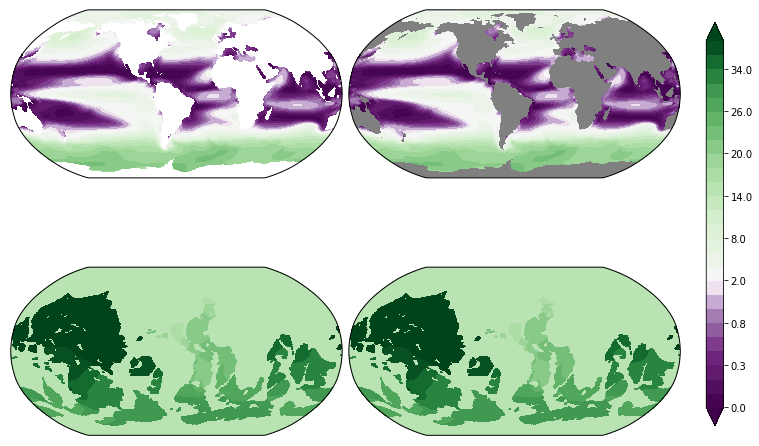

In [4]:
ncol = 2
nrow = 2
contour_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 1.5, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 34, 38, 42]
fig = plt.figure(figsize=(ncol*6,nrow*4))
# Top row: surface without specifying fill value, surface with specifying fill value 
ax00 = fig.add_subplot(2, 2, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf00 = ax00.contourf(lon_s, lat_s, field_s,
                                   transform=ccrs.PlateCarree(),
                                   levels=contour_levels,
                                   extend='both',
                                   cmap='PRGn',
                                   norm=MidPointNorm(midpoint=2))
ax01 = fig.add_subplot(2, 2, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf01 = ax01.contourf(lon_s, lat_s, field_s,
                                   transform=ccrs.PlateCarree(),
                                   levels=contour_levels,
                                   extend='both',
                                   cmap='PRGn',
                                   norm=MidPointNorm(midpoint=2))

# Bottom row: depth without specifying fill value, surface with specifying fill value 
ax10 = fig.add_subplot(2, 2, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf10 = ax10.contourf(lon_4k, lat_4k, field_4k,
                                     transform=ccrs.PlateCarree(),
                                     levels=contour_levels,
                                     extend='both',
                                     cmap='PRGn',
                                     norm=MidPointNorm(midpoint=2))
ax11 = fig.add_subplot(2, 2, 4, projection=ccrs.Robinson(central_longitude=305.0))
cf11 = ax11.contourf(lon_4k, lat_4k, field_4k,
                                     transform=ccrs.PlateCarree(),
                                     levels=contour_levels,
                                     extend='both',
                                     cmap='PRGn',
                                     norm=MidPointNorm(midpoint=2))

# Finalize figure
ax01.background_patch.set_facecolor('gray')
fig.subplots_adjust(hspace=0.45, wspace=0.02, right=0.9)
cax = plt.axes((0.93, 0.15, 0.02, 0.7))
fig.colorbar(cf00, cax=cax)


In [5]:
print('surface: {} - {}; nan? {}'.format(np.nanmin(field_s), np.nanmax(field_s), np.min(field_s)))
print('4000m: {} - {}; nan? {}'.format(np.nanmin(field_4k), np.nanmax(field_4k), np.min(field_4k)))

surface: -0.12473247200250626 - 22.963336944580078; nan? nan
4000m: 13.53673267364502 - 48.95629119873047; nan? nan


/glade/work/mlevy/miniconda3/envs/pangeo-cheyenne/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


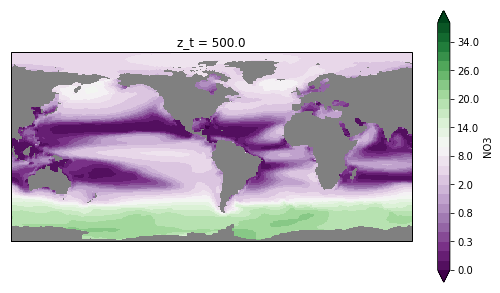

In [6]:
plt.figure(figsize=(9,5));
ax_surface = plt.axes(projection=ccrs.PlateCarree(central_longitude=280));
ax_surface.background_patch.set_facecolor('gray')
field_surface.plot.pcolormesh(ax=ax_surface, x='TLONG', y='TLAT', transform=ccrs.PlateCarree(),
                                     levels=contour_levels,
                                     extend='both',
                                     cmap='PRGn')

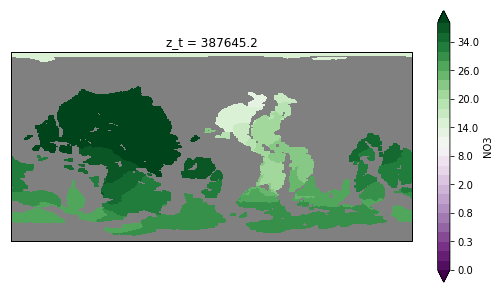

In [7]:
plt.figure(figsize=(9,5));
ax_4000m = plt.axes(projection=ccrs.PlateCarree(central_longitude=280));
ax_4000m.background_patch.set_facecolor('gray')
field_4000m.plot.pcolormesh(ax=ax_4000m, x='TLONG', y='TLAT', transform=ccrs.PlateCarree(),
                                     levels=contour_levels,
                                     extend='both',
                                     cmap='PRGn')